## Análisis de Ingresos mayores de $30,000 en los Hogares en México:

El análisis del ingreso de los hogares es fundamental para entender patrones socioeconómicos y apoyar en la toma de decisiones de política pública y estrategias económicas. En este proyecto, se explora y modela información proveniente de la Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) 2022. El objetivo principal es clasificar hogares según si tienen un ingreso alto o bajo, utilizando como umbral un ingreso trimestral superior a $30,000. Se implementa una metodología basada en regresión logística, con validación cruzada y evaluación mediante la curva ROC, para determinar la calidad predictiva del modelo generado.

### 1 Importación y creación de variable binaria
- Se crean los datos (`datos_procesados.csv`) usando las diferentes tablas.
- Se crea una nueva variable binaria llamada `alto_ingreso`, la cual indica si el ingreso trimestral es alto (mayor a 30,000).


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


if not pd.io.common.file_exists('datos_procesados.csv'):
    gastos_df = pd.read_csv("conjunto_de_datos_gastoshogar_enigh2022_ns.csv", low_memory=False)
    ingresos_df = pd.read_csv("conjunto_de_datos_ingresos_enigh2022_ns.csv", low_memory=False)
    viviendas_df = pd.read_csv("conjunto_de_datos_viviendas_enigh2022_ns.csv", low_memory=False)

    gastos_df["gasto_tri"] = pd.to_numeric(gastos_df["gasto_tri"].replace(' ', np.nan), errors='coerce')
    ingresos_df["ing_tri"] = pd.to_numeric(ingresos_df["ing_tri"].replace(' ', np.nan), errors='coerce')

    gastos_agrupados = gastos_df.groupby("folioviv", as_index=False)["gasto_tri"].sum()
    gastos_agrupados.rename(columns={"gasto_tri": "gastoTot_tri"}, inplace=True)

    ingresos_agrupados = ingresos_df.groupby("folioviv", as_index=False)["ing_tri"].sum()
    ingresos_agrupados.rename(columns={"ing_tri": "ingTot_tri"}, inplace=True)

    variables_categoricas = ["tipo_viv", "mat_pared", "mat_techos", "mat_pisos", "disp_agua", "dotac_agua", "excusado", "drenaje", "disp_elect", "combustible", "eli_basura", "tenencia", "tipo_adqui", "viv_usada", "tipo_finan", "tam_loc", "est_socio"]
    viviendas_df = pd.get_dummies(viviendas_df, columns=variables_categoricas, drop_first=True)

    df_final = pd.merge(gastos_agrupados, ingresos_agrupados, on="folioviv", how="outer")
    df_final = pd.merge(df_final, viviendas_df, on="folioviv", how="left")
    df_final.fillna(0, inplace=True)

    df_final.to_csv('datos_procesados.csv', index=False)
else:
    df_final = pd.read_csv('datos_procesados.csv')


df_final['alto_ingreso'] = (df_final['ingTot_tri'] > 30000).astype(int)


### 2 División de los datos (80/20)
- Se dividen los datos en conjuntos de entrenamiento (80%) y prueba (20%).
- Se mantiene un balance de clases.
- Se imprimen las proporciones para verificar el balance en datos originales, entrenamiento y prueba.


In [41]:


X = df_final.drop(['alto_ingreso', 'ingTot_tri', 'folioviv'], axis=1)
y = df_final['alto_ingreso']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


print("Proporción original:\n", df_final['alto_ingreso'].value_counts(normalize=True))
print("Proporción entrenamiento:\n", y_train.value_counts(normalize=True))
print("Proporción prueba:\n", y_test.value_counts(normalize=True))


Proporción original:
 alto_ingreso
1    0.6304
0    0.3696
Name: proportion, dtype: float64
Proporción entrenamiento:
 alto_ingreso
1    0.630401
0    0.369599
Name: proportion, dtype: float64
Proporción prueba:
 alto_ingreso
1    0.630397
0    0.369603
Name: proportion, dtype: float64


### 3 Validación cruzada con regresión logística
- Se aplica una validación cruzada (5-fold) usando los datos de entrenamiento para estimar la exactitud del modelo.
- El modelo utilizado es una regresión logística con un máximo de 2000 iteraciones para garantizar su convergencia.


In [42]:


modelo = LogisticRegression(max_iter=2000)
scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='accuracy')
print("Exactitud validación cruzada:", scores.mean())


Exactitud validación cruzada: 0.8207520474213545


### 4 Entrenamiento del modelo y evaluación
- Se entrena un modelo de regresión logística en todo el conjunto de entrenamiento.
- Se predicen probabilidades en el conjunto de prueba.
- Se evalúa el rendimiento del modelo usando tres umbrales distintos:
  - **0.5** (predeterminado)
  - **0.7** (más exigente)
  - **0.3** (más permisivo)
- Se reportan exactitud, sensibilidad y especificidad para cada umbral utilizando la matriz de confusión.


In [43]:


modelo.fit(X_train, y_train)

y_proba = modelo.predict_proba(X_test)[:, 1]

for umbral in [0.5, 0.7, 0.3]:
    y_pred = (y_proba >= umbral).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])

    print(f"\nEvaluación con umbral: {umbral}")
    print("Matriz de confusión:\n", cm)
    print("Exactitud:", accuracy)
    print("Sensibilidad:", recall)
    print("Especificidad:", specificity)



Evaluación con umbral: 0.5
Matriz de confusión:
 [[4890 1676]
 [1505 9694]]
Exactitud: 0.8209400506614128
Sensibilidad: 0.865613001160818
Especificidad: 0.744745659457813

Evaluación con umbral: 0.7
Matriz de confusión:
 [[5793  773]
 [3060 8139]]
Exactitud: 0.7842386715451731
Sensibilidad: 0.7267613179748191
Especificidad: 0.8822723119098386

Evaluación con umbral: 0.3
Matriz de confusión:
 [[ 3553  3013]
 [  523 10676]]
Exactitud: 0.8009569377990431
Sensibilidad: 0.9532994017322975
Especificidad: 0.5411209259823332


### 5 Curva ROC y valor de AUC
- Se genera y grafica la curva ROC, que visualiza la capacidad predictiva del modelo.
- Se calcula el área bajo la curva (AUC), valor que resume la calidad global del modelo: un valor cercano a 1 indica muy buen desempeño, mientras que un valor cercano a 0.5 indica desempeño aleatorio.


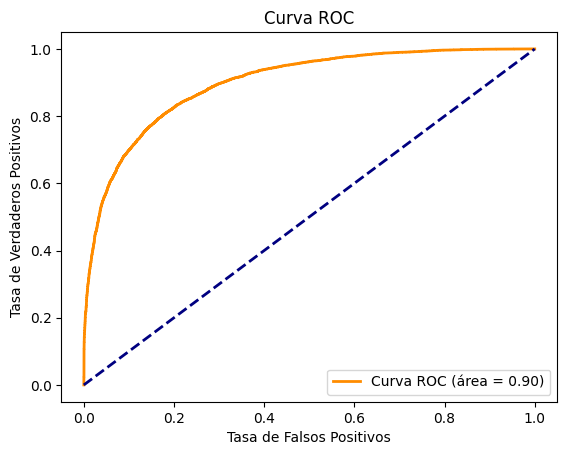

In [44]:

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


### 6 Interpretación de los resultados del modelo
El modelo de regresión logística generó un valor de AUC = 0.90, indicando un desempeño excelente. Esto significa que el modelo tiene una alta capacidad para discriminar correctamente entre hogares con ingresos altos (mayores a $30,000 trimestrales) y hogares con ingresos bajos.

In [45]:

coeficientes = pd.Series(modelo.coef_[0], index=X.columns)
print("Coeficientes:\n", coeficientes.sort_values(ascending=False))

Coeficientes:
 gastoTot_tri     3.359401
pago_viv         0.296138
tot_hom          0.292043
tot_resid        0.277756
renta            0.244359
                   ...   
combustible_1   -0.124517
tenencia_4      -0.139230
est_dis         -0.155350
tenencia_2      -0.206148
pago_mesp       -0.338350
Length: 127, dtype: float64


### Conclusión

El modelo de regresión logística entrenado logró un alto rendimiento, con un valor de AUC igual a 0.90, lo cual indica una excelente capacidad predictiva para distinguir hogares con ingresos altos frente a aquellos con ingresos más bajos. La validación cruzada confirmó una exactitud robusta, respaldando la consistencia del modelo. Las variables que más influyen en clasificar un hogar como de alto ingreso incluyen el gasto trimestral total, el tipo de pago por la vivienda y ciertas condiciones estructurales y de tenencia de la vivienda.

## Referencias
- INEGI (2022). Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) 2022. Disponible en: https://www.inegi.org.mx/app/descarga/ficha.html?tit=1626216&ag=0&f=csv
- ChatGPT (2025). Análisis y Modelado de Datos en Python. Generado con inteligencia artificial por OpenAI. 